<a href="https://colab.research.google.com/github/annsarapaul/TextClassification/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RNNs to do detect Sarcasms


Reference

https://pytorch.org/tutorials/beginner/nlp/pytorch_tutorial.html#sphx-glr-beginner-nlp-pytorch-tutorial-py


https://pytorch.org/tutorials/beginner/nlp/deep_learning_tutorial.html#sphx-glr-beginner-nlp-deep-learning-tutorial-py

https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#sphx-glr-beginner-nlp-sequence-models-tutorial-py

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0

https://github.com/prakashpandey9/Text-Classification-Pytorch



I started with the code from https://github.com/prakashpandey9/Text-Classification-Pytorch after attempting to do some text pre-processing w/o libraries.




In [1]:
cd /content/drive/MyDrive/NLP/Project/

/content/drive/MyDrive/NLP/Project


In [2]:
ls

 Project.ipynb          Sarcasm_Headlines_Dataset.json
'Project Report.gdoc'   Sarcasm_Headlines_Dataset_v2.json


# Classification Models


## Library

In [3]:
import os
import time
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import sys
from torchtext import data
from torchtext.vocab import Vectors, GloVe
from sklearn import metrics 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

learning_rate = 2e-5
batch_size = 32
output_size = 2
hidden_size = 256
layer_size = 2
embedding_length = 300
sentence_size = 40

In [4]:
#!pip3 install torchtext==0.2.3

## Load Data

In [5]:
def load_dataset(test_sen=None):

    """
    tokenizer : Breaks sentences into a list of words. If sequential=False, no tokenization is applied
    Field : A class that stores information about the way of preprocessing
    fix_length : An important property of TorchText is that we can let the input to be variable length, and TorchText will
                 dynamically pad each sequence to the longest sequence in that "batch". But here we are using fi_length which
                 will pad each sequence to have a fix length of 200.
                 
    build_vocab : It will first make a vocabulary or dictionary mapping all the unique words present in the train_data to an
                  idx and then after it will use GloVe word embedding to map the index to the corresponding word embedding.
                  
    vocab.vectors : This returns a torch tensor of shape (vocab_size x embedding_dim) containing the pre-trained word embeddings.
    BucketIterator : Defines an iterator that batches examples of similar lengths together to minimize the amount of padding needed.
    
    """
    
    tokenize = lambda x: x.split()
    TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=sentence_size)
    LABEL = data.LabelField(tensor_type=torch.FloatTensor)
    raw_data = data.TabularDataset(path='Sarcasm_Headlines_Dataset.json', format = 'JSON',fields={'is_sarcastic': ('label', LABEL), 'headline': ('text', TEXT)})
    train_data, val_data, test_data = raw_data.split(split_ratio=[0.7,0.2,0.1], stratified=True,strata_field='label')
    #train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
    TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=embedding_length))
    LABEL.build_vocab(train_data)

    word_embeddings = TEXT.vocab.vectors
    print ("Length of Text Vocabulary: " + str(len(TEXT.vocab)))
    print ("Vector size of Text Vocabulary: ", TEXT.vocab.vectors.size())
    print ("Label Length: " + str(len(LABEL.vocab)))

    #train_data, valid_data = train_data.split() # Further splitting of training_data to create new training_data & validation_data
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, val_data, test_data), batch_size=batch_size, sort_key=lambda x: len(x.text), repeat=False, shuffle=True)

    vocab_size = len(TEXT.vocab)

    return TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter


In [6]:
#Load Dataset

TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter = load_dataset()

for x in train_iter:
  print(x.text[0][0]) # Sample sentence, padded to 40 with 1s
  print(x.text[1][0]) # Actual Length
  break

Length of Text Vocabulary: 29824
Vector size of Text Vocabulary:  torch.Size([29824, 300])
Label Length: 2
tensor([ 2402,  3841,   235,    61,    68, 24977,  5614,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
       device='cuda:0')
tensor(7, device='cuda:0')


In [19]:
print(len(train_iter)*32)
print(len(valid_iter)*32)
print(len(test_iter)*32)

18720
2688
5344


## Models

In [7]:

class LSTMClassifier(nn.Module):
	def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, weights):
		super(LSTMClassifier, self).__init__()
		
		"""
		Arguments
		---------
		batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
		output_size : 2 = (pos, neg)
		hidden_sie : Size of the hidden_state of the LSTM
		vocab_size : Size of the vocabulary containing unique words
		embedding_length : Embeddding dimension of GloVe word embeddings
		weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 
		
		"""
		
		self.batch_size = batch_size
		self.output_size = output_size
		self.hidden_size = hidden_size
		self.vocab_size = vocab_size
		self.embedding_length = embedding_length
		
		self.word_embeddings = nn.Embedding(vocab_size, embedding_length)# Initializing the look-up table.
		self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False) # Assigning the look-up table to the pre-trained GloVe word embedding.
		self.lstm = nn.LSTM(embedding_length, hidden_size)
		self.label = nn.Linear(hidden_size, output_size)
		
	def forward(self, input_sentence, batch_size=None):
	
		""" 
		Parameters
		----------
		input_sentence: input_sentence of shape = (batch_size, num_sequences)
		batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
		
		Returns
		-------
		Output of the linear layer containing logits for positive & negative class which receives its input as the final_hidden_state of the LSTM
		final_output.shape = (batch_size, output_size)
		
		"""
		
		''' Here we will map all the indexes present in the input sequence to the corresponding word vector using our pre-trained word_embedddins.'''
		input = self.word_embeddings(input_sentence) # embedded input of shape = (batch_size, num_sequences,  embedding_length)
		input = input.permute(1, 0, 2) # input.size() = (num_sequences, batch_size, embedding_length)
		if batch_size is None:
			h_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda()) # Initial hidden state of the LSTM
			c_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda()) # Initial cell state of the LSTM
		else:
			h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
		output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
		final_output = self.label(final_hidden_state[-1]) # final_hidden_state.size() = (1, batch_size, hidden_size) & final_output.size() = (batch_size, output_size)
		final_output = F.softmax(final_output, dim=1) #batch_size, output_size)
		return final_output

In [8]:
class BLSTM_Classifier(nn.Module):
	def __init__(self, batch_size, output_size, hidden_size, sentence_size, vocab_size, embedding_length, weights):
		super(BLSTM_Classifier, self).__init__()
		
		"""
		Arguments
		---------
		batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
		output_size : 2 = (pos, neg)
		hidden_sie : Size of the hidden_state of the LSTM
		vocab_size : Size of the vocabulary containing unique words
		embedding_length : Embeddding dimension of GloVe word embeddings
		weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 
		
		"""
		
		self.batch_size = batch_size
		self.output_size = output_size
		self.hidden_size = hidden_size
		self.vocab_size = vocab_size
		self.embedding_length = embedding_length
		self.sentence_size = sentence_size
		self.word_embeddings = nn.Embedding(vocab_size, embedding_length)# Initializing the look-up table.
		self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False) # Assigning the look-up table to the pre-trained GloVe word embedding.
		self.lstm = nn.LSTM(embedding_length, hidden_size, bidirectional = True)
		self.cnn2 = nn.Conv2d(in_channels=1,out_channels=1, kernel_size=3)
		self.maxpoold2d = nn.MaxPool2d(kernel_size=2)
		#self.label = nn.Linear(hidden_size, output_size)
		linear_size = int((sentence_size - 2)*(hidden_size - 2)/4)
		self.label = nn.Linear(linear_size, output_size)
  
	def forward(self, input_sentence, batch_size=None):
	
		""" 
		Parameters
		----------
		input_sentence: input_sentence of shape = (batch_size, num_sequences)
		batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
		
		Returns
		-------
		Output of the linear layer containing logits for positive & negative class which receives its input as the final_hidden_state of the LSTM
		final_output.shape = (batch_size, output_size)
		
		"""
		
		''' Here we will map all the indexes present in the input sequence to the corresponding word vector using our pre-trained word_embedddins.'''
		input = self.word_embeddings(input_sentence) # embedded input of shape = (batch_size, num_sequences,  embedding_length)
		input = input.permute(1, 0, 2) # input.size() = (num_sequences, batch_size, embedding_length)

		if batch_size is None:
			batch_size = self.batch_size
			h_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda()) # Initial hidden state of the LSTM
			c_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda()) # Initial cell state of the LSTM
		else:
			h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
		output, (final_hidden_state, final_cell_state) = self.lstm(input)
		out_for = output[:,:,:self.hidden_size] #Extract output of forward
		out_back = output[:,:,self.hidden_size:] #Extract output of backward
		out = out_for + out_back #Element-wise addition
		out = out.permute(1, 0, 2) # out= (batchsize, num_seq , hidden_units) from (num_seq, batchsize,hidden_units)
		out = out.view(batch_size,1,out.size()[1],self.hidden_size)
		out = self.cnn2(out)
		out = self.maxpoold2d(out)
		out = out.view(batch_size, -1)
		final_output = self.label(out) 
		final_output = F.softmax(final_output, dim=1) #(batch_size, output_size)
		return final_output

In [103]:
"""
#Troubleshoot Code
model = BLSTM_Classifier(batch_size, output_size, hidden_size, 40, vocab_size, embedding_length, word_embeddings)
for batch in train_iter:
  text = batch.text[0]
  if torch.cuda.is_available():
    text = text.cuda()
  print(text.size())
  model.cuda()
  prediction = model.forward(text)
  print(prediction.size())
  #print(prediction)
  break

"""



torch.Size([32, 40])
torch.Size([32, 2])


In [ ]:
"""
x = torch.rand([5, 3, 4])
print(x)
print(x.size())
#print(x[-1])
#x = x[-1].view(1,5,10)
y1 = x[:,:,:2]
y2 = x[:,:,2:]
y = y1 + y2
print(y)
print(y.size())

y.
"""

In [9]:

class LSTM_MultiLayer_Classifier(nn.Module):
	def __init__(self, batch_size, output_size, hidden_size, layer_size, vocab_size, embedding_length, weights):
		super(LSTM_MultiLayer_Classifier, self).__init__()
		
		"""
		Arguments
		---------
		batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
		output_size : 2 = (pos, neg)
		hidden_sie : Size of the hidden_state of the LSTM
		vocab_size : Size of the vocabulary containing unique words
		embedding_length : Embeddding dimension of GloVe word embeddings
		weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 
		
		"""
		
		self.batch_size = batch_size
		self.output_size = output_size
		self.hidden_size = hidden_size
		self.layer_size = layer_size
		self.vocab_size = vocab_size
		self.embedding_length = embedding_length
		
		self.word_embeddings = nn.Embedding(vocab_size, embedding_length)# Initializing the look-up table.
		self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False) # Assigning the look-up table to the pre-trained GloVe word embedding.
		self.lstm = nn.LSTM(embedding_length, hidden_size, num_layers = layer_size)
		self.label = nn.Linear(hidden_size, output_size)
		
	def forward(self, input_sentence, batch_size=None):
	
		""" 
		Parameters
		----------
		input_sentence: input_sentence of shape = (batch_size, num_sequences)
		batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
		
		Returns
		-------
		Output of the linear layer containing logits for positive & negative class which receives its input as the final_hidden_state of the LSTM
		final_output.shape = (batch_size, output_size)
		
		"""
		
		''' Here we will map all the indexes present in the input sequence to the corresponding word vector using our pre-trained word_embedddins.'''
		input = self.word_embeddings(input_sentence) # embedded input of shape = (batch_size, num_sequences,  embedding_length)
		input = input.permute(1, 0, 2) # input.size() = (num_sequences, batch_size, embedding_length)
		if batch_size is None:
			h_0 = Variable(torch.zeros(self.layer_size, self.batch_size, self.hidden_size).cuda()) # Initial hidden state of the LSTM
			c_0 = Variable(torch.zeros(self.layer_size, self.batch_size, self.hidden_size).cuda()) # Initial cell state of the LSTM
		else:
			h_0 = Variable(torch.zeros(self.layer_size, batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(self.layer_size, batch_size, self.hidden_size).cuda())
		output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
		final_output = self.label(final_hidden_state[-1]) # final_hidden_state.size() = (1, batch_size, hidden_size) & final_output.size() = (batch_size, output_size)
		final_output = F.softmax(final_output, dim=1) #batch_size, output_size)
		return final_output

In [10]:
#Functions

def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)
    
def train_model(model, train_iter, epoch):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.cuda()
    optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
    steps = 0
    model.train()
    for idx, batch in enumerate(train_iter):
        text = batch.text[0] #0 is words , 1 is the length of sequence pre-padding, #batch_size x sequence length (40)
        target = batch.label #batch_size
        target = torch.autograd.Variable(target).long() #Convert to Int 0 and 1 (from float)
        if torch.cuda.is_available():
            text = text.cuda()
            target = target.cuda()
        if (text.size()[0] is not batch_size):# One of the batch returned by BucketIterator has length different than 32.
            continue
        optim.zero_grad()
        prediction = model(text)
        loss = loss_fn(prediction, target)
        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()
        acc = 100.0 * num_corrects/len(batch)
        loss.backward()
        clip_gradient(model, 1e-1)
        optim.step()
        steps += 1
        
        #if steps % 100 == 0:
        #    print (f'Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
        
        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()
        
    return total_epoch_loss/len(train_iter), total_epoch_acc/len(train_iter)

def eval_model(model, val_iter):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.eval()
    total_target = torch.zeros(0).cuda()
    total_pred = torch.zeros(0).cuda()
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            text = batch.text[0]
            if (text.size()[0] is not batch_size):
                continue
            target = batch.label
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            prediction = model(text)
            loss = loss_fn(prediction, target)
            pred = torch.max(prediction, 1)[1].view(target.size())
            total_pred = torch.cat((total_pred,pred.data))
            total_target = torch.cat((total_target,target.data ))
            num_corrects = (pred.data == target.data).sum()
            acc = 100.0 * num_corrects/len(batch)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()
        precision_score_eval = metrics.precision_score(total_target.cpu(), total_pred.cpu())
        recall_score_eval = metrics.recall_score(total_target.cpu(), total_pred.cpu())

    return total_epoch_loss/len(val_iter), total_epoch_acc/len(val_iter), precision_score_eval, recall_score_eval

In [25]:
"""
total_target = torch.zeros(0).cuda()
total_pred = torch.zeros(0).cuda()
i = 0
for x in valid_iter:
  prediction = model(x.text[0])
  target = x.label
  target = torch.autograd.Variable(target).long()
  pred = torch.max(prediction, 1)[1].view(target.size())
  total_pred = torch.cat((total_pred,pred.data))
  total_target = torch.cat((total_target,target.data ))
  if i == 2:
    break
  i = i + 1

print(total_target)
print(total_pred)
print(metrics.precision_score(total_target.cpu(), total_pred.cpu()))  
print(total_pred.size())

"""

'\ntotal_target = torch.zeros(0).cuda()\ntotal_pred = torch.zeros(0).cuda()\ni = 0\nfor x in valid_iter:\n  prediction = model(x.text[0])\n  target = x.label\n  target = torch.autograd.Variable(target).long()\n  pred = torch.max(prediction, 1)[1].view(target.size())\n  total_pred = torch.cat((total_pred,pred.data))\n  total_target = torch.cat((total_target,target.data ))\n  if i == 2:\n    break\n  i = i + 1\n\nprint(total_target)\nprint(total_pred)\nprint(metrics.precision_score(total_target.cpu(), total_pred.cpu()))  \nprint(total_pred.size())\n\n'

## Training and Evaluation

In [52]:
#model = LSTMClassifier(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
#model = LSTM_MultiLayer_Classifier(batch_size, output_size, hidden_size, layer_size, vocab_size, embedding_length, word_embeddings)
model = BLSTM_Classifier(batch_size, output_size, 122, sentence_size, vocab_size, embedding_length, word_embeddings)

loss_fn = F.cross_entropy
train_loss_all = []
train_acc_all = []
val_loss_all = []
val_acc_all = []
for epoch in range(20):
    train_loss, train_acc = train_model(model, train_iter, epoch)
    val_loss, val_acc, val_prec, val_recall = eval_model(model, valid_iter)
    train_loss_all.append(train_loss)
    train_acc_all.append(train_acc)
    val_loss_all.append(val_loss)
    val_acc_all.append(val_acc)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.2f}%, Val. Prec: {val_prec:3f}, Val. Recall: {val_recall:3f}')
#eval_model(model, test_iter)
#test_loss, test_acc, test_prec, test_recall  = eval_model(model, test_iter)
#print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}%, , Test Recall: {test_recall:.2f}%, , Test Precision: {test_prec:.2f}%')


/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:321: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train), lengths


Epoch: 01, Train Loss: 0.535, Train Acc: 75.80%, Val. Loss: 0.486683, Val. Acc: 79.95%, Val. Prec: 0.805426, Val. Recall: 0.742241
Epoch: 02, Train Loss: 0.457, Train Acc: 84.84%, Val. Loss: 0.461476, Val. Acc: 82.85%, Val. Prec: 0.838113, Val. Recall: 0.781034
Epoch: 03, Train Loss: 0.423, Train Acc: 88.45%, Val. Loss: 0.456828, Val. Acc: 83.11%, Val. Prec: 0.842937, Val. Recall: 0.781897
Epoch: 04, Train Loss: 0.398, Train Acc: 91.20%, Val. Loss: 0.456595, Val. Acc: 83.00%, Val. Prec: 0.798054, Val. Recall: 0.848276
Epoch: 05, Train Loss: 0.379, Train Acc: 93.30%, Val. Loss: 0.453868, Val. Acc: 83.74%, Val. Prec: 0.837959, Val. Recall: 0.806897
Epoch: 06, Train Loss: 0.366, Train Acc: 94.58%, Val. Loss: 0.458711, Val. Acc: 83.15%, Val. Prec: 0.872105, Val. Recall: 0.746552
Epoch: 07, Train Loss: 0.357, Train Acc: 95.52%, Val. Loss: 0.468058, Val. Acc: 82.40%, Val. Prec: 0.893757, Val. Recall: 0.703448
Epoch: 08, Train Loss: 0.350, Train Acc: 96.15%, Val. Loss: 0.451988, Val. Acc: 83.

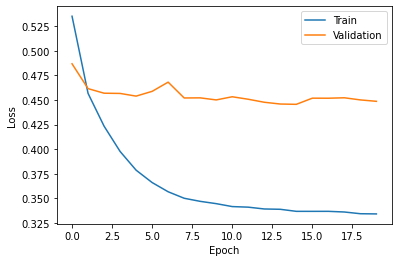

In [53]:
import matplotlib.pyplot as plt
plt.plot(train_loss_all, label='Train')
plt.plot(val_loss_all, label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show() 


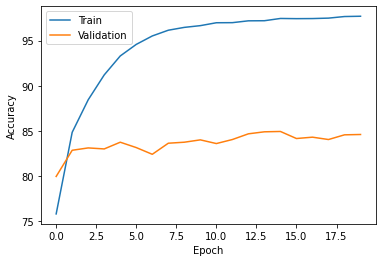

In [54]:
plt.plot(train_acc_all, label='Train')
plt.plot(val_acc_all, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show() 


In [51]:
def predict_one(test_sen):
  test_sen = TEXT.preprocess(test_sen)
  y = [TEXT.vocab.stoi[x] for x in test_sen]
  test_sen = [np.pad(y, (0,sentence_size-len(y)), 'constant', constant_values = 1)]
  #test_sen = [[TEXT.vocab.stoi[x] for x in test_sen]]
  test_sen = np.asarray(test_sen)
  #test_sen = np.pad(test_sen, (0,sentence_size-len(test_sen)), 'constant', constant_values = 1)
  test_sen = torch.LongTensor(test_sen)
  test_tensor = Variable(test_sen) #pad to 40
  test_tensor = test_tensor.cuda()
  model.eval()
  output = model(test_tensor, 1)
  out = F.softmax(output, 1)
  #print(output)
  if (torch.argmax(out[0]) == 1):
      print ("Sentiment: Positive")
  else:
      print ("Sentiment: Negative")

''' Let us now predict the sentiment on a single sentence just for the testing purpose. '''
test_sen1 = "Alien from another planet"
test_sen2 = "Protest was held in the city"


predict_one(test_sen1)
predict_one(test_sen2)






Sentiment: Positive
Sentiment: Negative


In [21]:
x = np.array([123,3,4])

In [27]:
np.pad(x, (0,8-len(x)), 'constant', constant_values = 1)

array([123,   3,   4,   1,   1,   1,   1,   1])